In [ ]:
!pip install torch numpy gymnasium matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyPi(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.classify = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.classify(outs)
        return logits

policy_pi = PolicyPi().to(device)

In [ ]:
gamma = 0.99

# Pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = policy_pi(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make("CartPole-v1")
reward_records = []
opt = torch.optim.AdamW(policy_pi.parameters(), lr=0.001)
for i in range(1000):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    opt.zero_grad()
    logits = policy_pi(states)
    # Calculate negative log probability (-log P) as loss.
    # Cross-entropy loss is -log P in categorical distribution. (see above)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    loss = -log_probs * cum_rewards
    loss.sum().backward()
    opt.step()

    # Record total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, sum(rewards)), end="\r")
    reward_records.append(sum(rewards))

print("\nDone")
env.close()

Run episode999 with rewards 500.0
Done


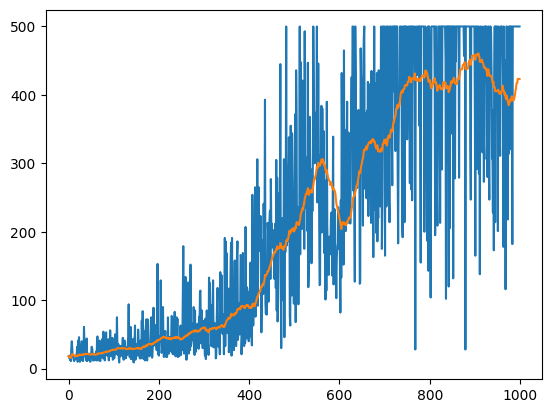

In [ ]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
plt.plot(reward_records)
plt.plot(average_reward)

Actor-Critic Method in Reinforcement Learning


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

In [ ]:
gamma = 0.99

# pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make("CartPole-v1")
reward_records = []
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.001)
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.001)
for i in range(1500):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #

    # Optimize value loss (Critic)
    opt1.zero_grad()
    states = torch.tensor(states, dtype=torch.float).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    values = value_func(states)
    values = values.squeeze(dim=1)
    vf_loss = F.mse_loss(
        values,
        cum_rewards,
        reduction="none")
    vf_loss.sum().backward()
    opt1.step()

    # Optimize policy loss (Actor)
    with torch.no_grad():
        values = value_func(states)
    opt2.zero_grad()
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    advantages = cum_rewards - values
    logits = actor_func(states)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    pi_loss = -log_probs * advantages
    pi_loss.sum().backward()
    opt2.step()

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, sum(rewards)), end="\r")
    reward_records.append(sum(rewards))

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")
env.close()

Run episode1091 with rewards 500.0
Done


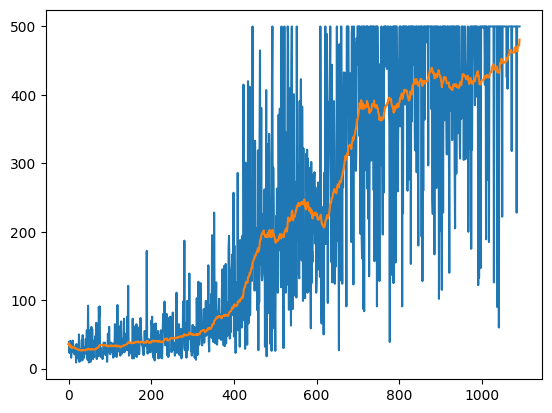

In [ ]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

PPO (Proximal Policy Optimization)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

In [ ]:
gamma = 0.99    # discount

# These coefficients are experimentally determined in practice.
kl_coeff = 0.20  # weight coefficient for KL-divergence loss
vf_coeff = 0.50  # weight coefficient for value loss

# Pick up action and following properties for state (s)
# Return :
#     action (int)       action
#     logits (list[int]) logits defining categorical distribution
#     logprb (float)     log probability
def pick_sample_and_logp(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        #   --> size : (1)
        a = torch.multinomial(probs, num_samples=1)
        #   --> size : ()
        a = a.squeeze(dim=0)
        # Calculate log probability
        logprb = -F.cross_entropy(logits, a, reduction="none")

        # Return
        return a.tolist(), logits.tolist(), logprb.tolist()

env = gym.make("CartPole-v1")
reward_records = []
all_params = list(actor_func.parameters()) + list(value_func.parameters())
opt = torch.optim.AdamW(all_params, lr=0.0005)
for i in range(5000):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    logits = []
    logprbs = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a, l, p = pick_sample_and_logp(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        logits.append(l)
        logprbs.append(p)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #
    opt.zero_grad()
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    logits_old = torch.tensor(logits, dtype=torch.float).to(device)
    logprbs = torch.tensor(logprbs, dtype=torch.float).to(device)
    logprbs = logprbs.unsqueeze(dim=1)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    cum_rewards = cum_rewards.unsqueeze(dim=1)
    # Get values and logits with new parameters
    values_new = value_func(states)
    logits_new = actor_func(states)
    # Get advantages
    advantages = cum_rewards - values_new
    ### # Uncomment if you use normalized advantages (see above note)
    ### advantages = (advantages - advantages.mean()) / advantages.std()
    # Calculate P_new / P_old
    logprbs_new = -F.cross_entropy(logits_new, actions, reduction="none")
    logprbs_new = logprbs_new.unsqueeze(dim=1)
    prob_ratio = torch.exp(logprbs_new - logprbs)
    # Calculate KL-div for Categorical distribution (see above)
    l0 = logits_old - torch.amax(logits_old, dim=1, keepdim=True) # reduce quantity
    l1 = logits_new - torch.amax(logits_new, dim=1, keepdim=True) # reduce quantity
    e0 = torch.exp(l0)
    e1 = torch.exp(l1)
    e_sum0 = torch.sum(e0, dim=1, keepdim=True)
    e_sum1 = torch.sum(e1, dim=1, keepdim=True)
    p0 = e0 / e_sum0
    kl = torch.sum(
        p0 * (l0 - torch.log(e_sum0) - l1 + torch.log(e_sum1)),
        dim=1,
        keepdim=True)
    # Get value loss
    vf_loss = F.mse_loss(
        values_new,
        cum_rewards,
        reduction="none")
    # Get total loss
    loss = -advantages * prob_ratio + kl * kl_coeff + vf_loss * vf_coeff
    # Optimize
    loss.sum().backward()
    opt.step()

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, np.sum(rewards)), end="\r")
    reward_records.append(np.sum(rewards))

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")
env.close()

Run episode2531 with rewards 500.0
Done


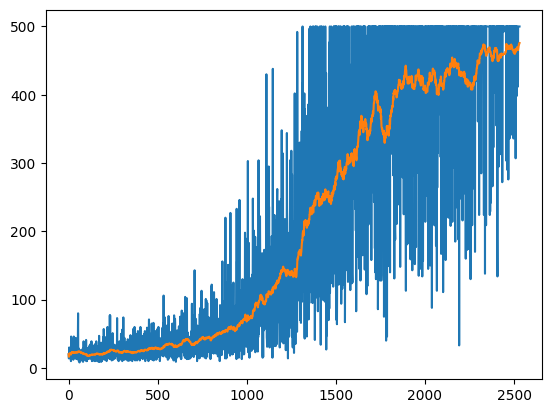

In [ ]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)